In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

In [8]:
'''
preparing fake preproc and graphwrap
'''

from graphlearn.processing import PreProcessor
from graphlearn.graph import Wrapper
import graphlearn
class mywrap(Wrapper):
    def clean(self):
        return
    def real_clean(self):
        graphlearn.graph.graph_clean(self._base_graph)

class mypp(PreProcessor):           
    def wrap(self,graph):
        return mywrap(graph,self.vectorizer)
    


In [4]:
%%time
'''
FIRST WE TRAIN A GRAPHSAMPLER
'''
import sys
sys.path.append('..')
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools


# setting things up...
training_graphs = gspan_to_eden( '../bursi.pos.gspan' )
training_size=200
training_graphs = itertools.islice(training_graphs,training_size)
sampler=gl.Sampler(radius_list=[0,1], thickness_list=[2],random_state=42447,
                          min_cip_count=2, min_interface_count=2,preprocessor=mypp())
#fitting sampler
sampler.fit(training_graphs)
#sampler.save('tmp/sampler_200.ge')
#loading sampler
#ampler.load('tmp/sampler_200.ge')


CPU times: user 7.36 s, sys: 580 ms, total: 7.94 s
Wall time: 16.4 s


In [5]:
'''
ok,lets set all the options just to make sure we didnt miss any
'''

# note, i just copy pasted  sample of graphlearn.sampler.. 
# this way we are flexible and dont have to think if future changes are incoming
probabilistic_core_choice=True
score_core_choice=False
max_core_size_diff=-1
similarity=-1
n_samples=None
proposal_probability=False
batch_size=10
target_orig_cip=False
quick_skip_orig_cip=False
select_cip_max_tries=20
burnin=0
generator_mode=False
omit_seed=True
keep_duplicates=False


sampler.proposal_probability = proposal_probability
sampler.similarity = similarity

if probabilistic_core_choice + score_core_choice + max_core_size_diff == -1 > 1:
    raise Exception('choose max one cip choice strategy')

#if n_samples:
#    sampler.sampling_interval = int((n_steps - burnin) / (n_samples + omit_seed - 1))
#else:
#    sampler.sampling_interval = 9999


sampler.quick_skip_orig_cip = quick_skip_orig_cip
sampler.target_orig_cip = target_orig_cip

# the user doesnt know about edge nodes.. so this needs to be done
max_core_size_diff = max_core_size_diff * 2
sampler.max_core_size_diff = max_core_size_diff

#  calculating the actual steps for improving :)
#sampler.improving_threshold = improving_threshold
#if improving_threshold > 0:
#    sampler.improving_threshold = int(sampler.improving_threshold * sampler.n_steps)
#sampler.improving_linear_start = improving_linear_start
#if improving_linear_start > 0:
#    sampler.improving_linear_start = int(improving_linear_start * n_steps)
#sampler.improving_penalty_per_step = (1 - accept_static_penalty) / float(sampler.improving_threshold - sampler.improving_linear_start)


sampler.select_cip_max_tries = select_cip_max_tries
sampler.burnin = burnin
sampler.omit_seed = omit_seed
sampler.batch_size = batch_size
sampler.probabilistic_core_choice = probabilistic_core_choice
sampler.score_core_choice = score_core_choice

sampler.generator_mode = generator_mode
sampler.keep_duplicates = keep_duplicates
# adapt grammar to task:
sampler.lsgg.preprocessing(4,
                        max_core_size_diff,
                        probabilistic_core_choice )

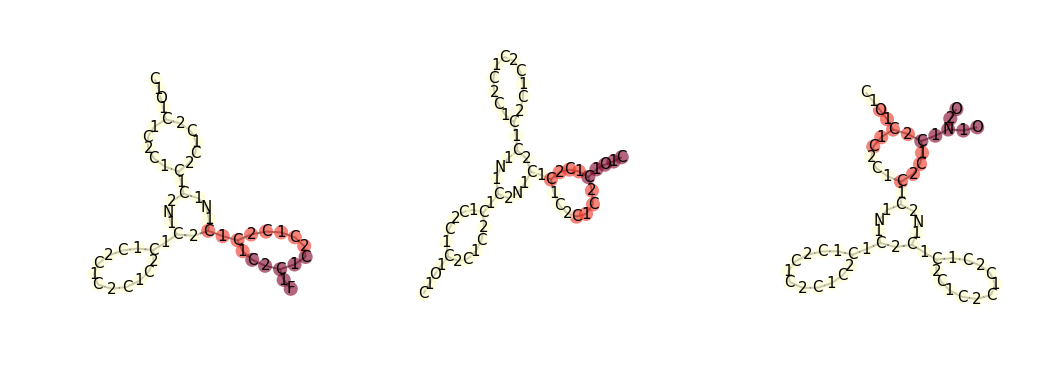

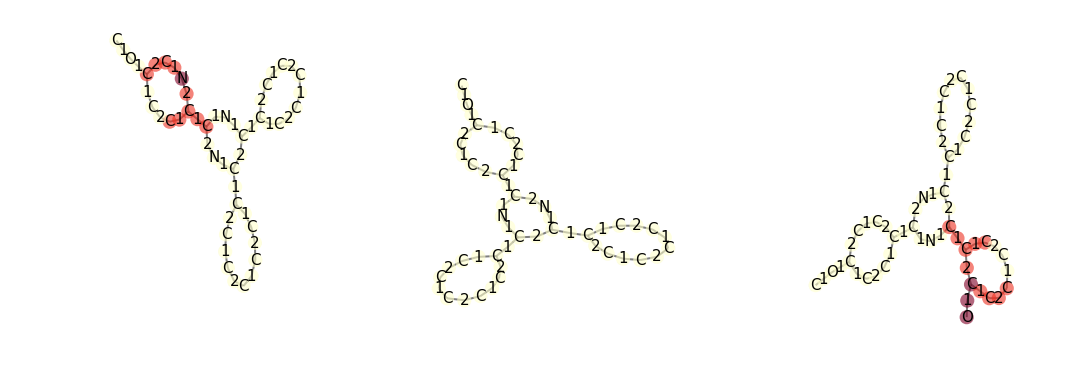

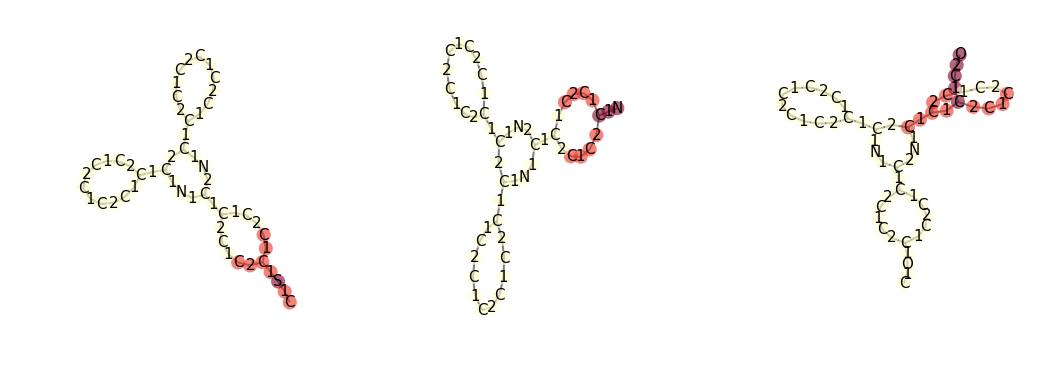

1


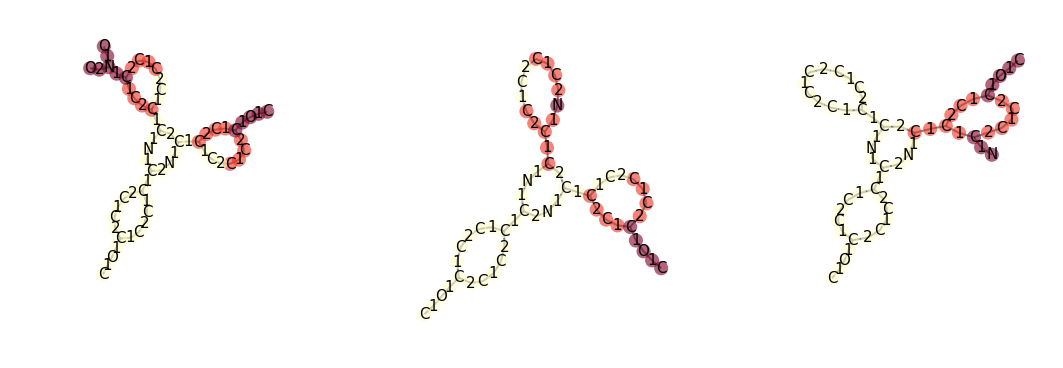

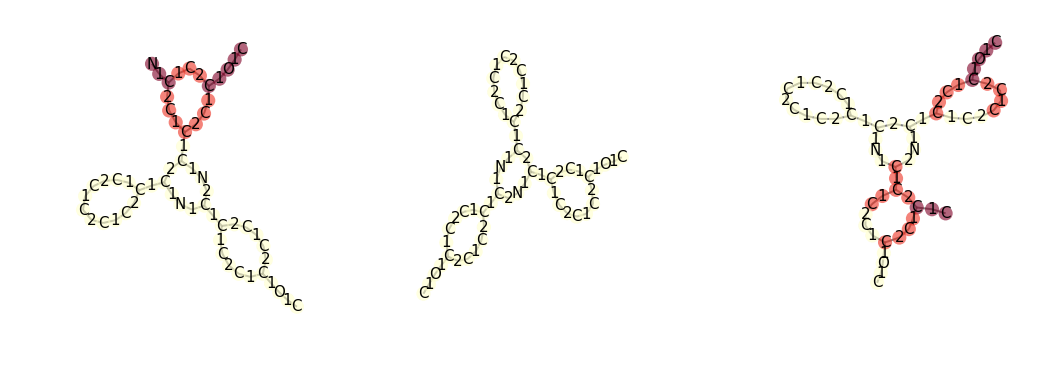

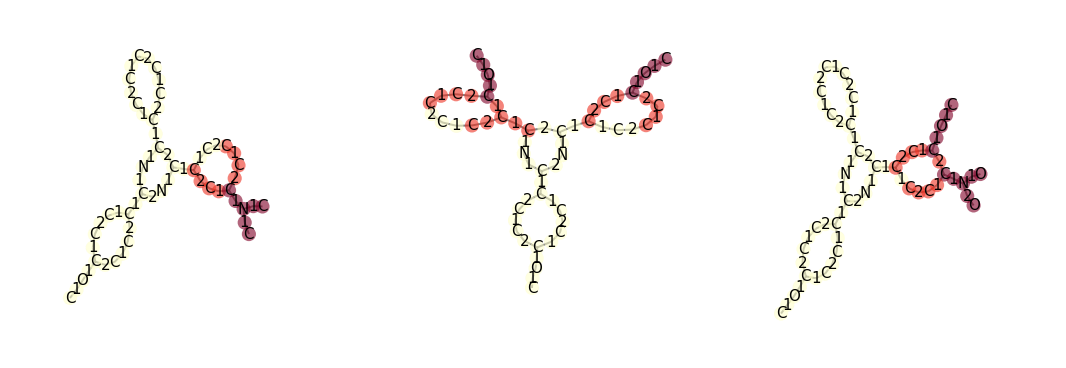

In [ ]:
'''
easy mode
'''
sampler.step=3 # whatever

import networkx as nx


def get_new_graphs(graphwrap):
    res=[]
    graphwrap.clean()
    res= [sampler._propose(graphwrap) for i in range(8)]
    #for i in range(8):
    #    gr2=      nx.Graph(gr)
    #    cip =     sampler.select_original_cip(gr2)
    #    newcip =  sampler._select_cips(cip).next()
    #    newgr=    graphtools.core_substitution(gr2, cip.graph, newcip.graph)
    #    res.append(newgr)
    return res

from graphlearn.utils import draw
gr = gspan_to_eden( '../bursi.pos.gspan' )
CURRENT = sampler._sample_init(gr.next())

while True:
    # generate 8 graphs
    graphmanz=get_new_graphs(CURRENT)
    # put old ine in middle
    
    g=[grman.base_graph() for grman in graphmanz ]
    g=g[:4]+[CURRENT.base_graph()]+g[4:]
    # draw them 
    draw.graphlearn(g,n_graphs_per_line=3, node_size=200)
    #pick one
    x=raw_input()
    CURRENT=graphmanz[int(x)]
    CURRENT.real_clean()

/Users/costa/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/costa/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


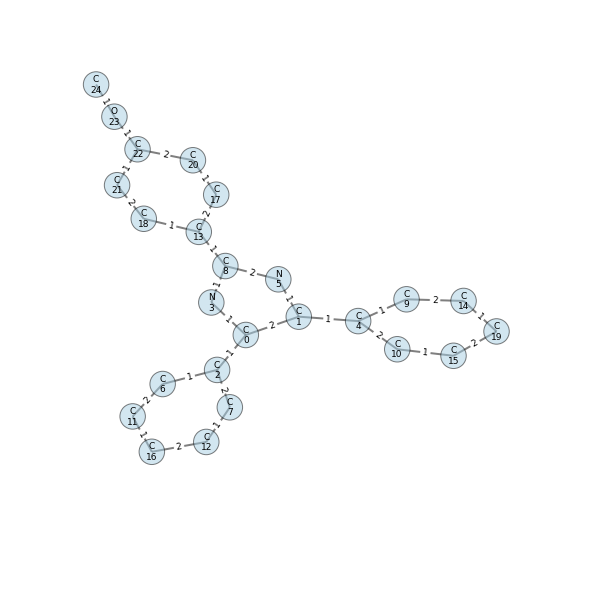

4


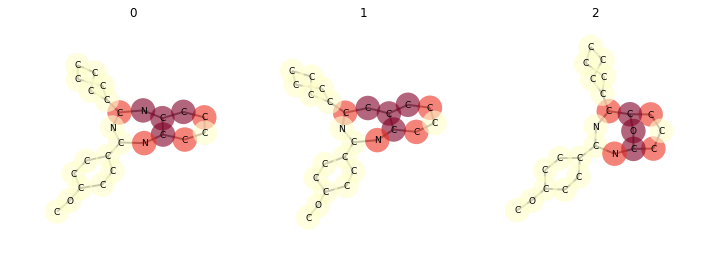

2


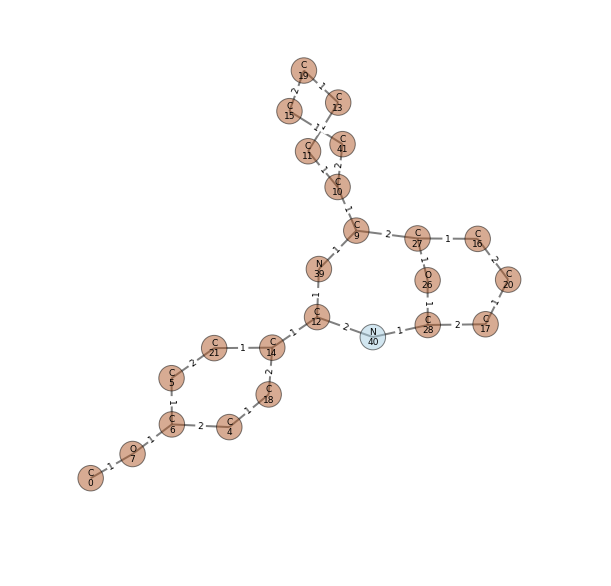

In [ ]:
%%time
'''
OLD maximum control mode
'''
from graphlearn import graphtools
import networkx as nx
from eden.util import display
from eden.modifier.graph.vertex_attributes import colorize 

def extract(x,graph):
    return graphtools.extract_core_and_interface(x, graph, [2], [2], 
            vectorizer=sampler.vectorizer,
            hash_bitmask=sampler.hash_bitmask, filter=sampler.node_entity_check)

def getids(graph):
    res=[]
    for n in graph.nodes():
        if 'edge' in graph.node[n]:
            continue
        cip=extract(n,graph)
        if not cip:
            continue
        if cip[0].interface_hash in sampler.lsgg.grammar:
            res.append(n)
    return res
            
    
def get_new_graphs(gr,cores,oldcip):
    res=[]
    graphtools.graph_clean(gr)
    news= [ cip.graph for cip in cores.itervalues() ]
    for i,core in enumerate(news):
        newgr=graphtools.core_substitution(gr,oldcip.graph,core)
        newgr.graph['info2']=str(i)
        res.append(newgr)
    return res

def set_id_label(graph):
    # not sure if this should be fixed in eden..
    # i suspect that eden sets an ID and then assumes that nobody will ever mess with it..
    # surely, nobody has the intent of replacing parts of the graph... or building a wall for that matter.. 
    for n,d in graph.nodes(data=True):
        d['ID']=str(n)
    

from graphlearn.utils.draw import draw_graph_set_graphlearn
gr = gspan_to_eden( 'bursi.pos.gspan' )
CURRENT = gr.next()
CURRENT = sampler.vectorizer._edge_to_vertex_transform(CURRENT)

    
while True:
    
    # draw graph and tell user which cores are ok to pick: 
    ids = getids(CURRENT)
    set_id_label(CURRENT)
    C=nx.Graph(CURRENT)
    C=sampler.vectorizer._revert_edge_to_vertex_transform(CURRENT)
    
    for n in ids:
        C.node[n]['color_level']=.5
    
    display.draw_graph(C, size=10, secondary_vertex_label='ID',
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, node_size=650)
    x=raw_input()
    x=int(x)
    
    
    #ok we have a node, lets get a cip
    cip =extract(x, CURRENT)
    cip=cip[0]
    
    # lets get all the hits in the grammar
    corez=sampler.lsgg.grammar[cip.interface_hash]
    
    # let the user choose from some options we get from get_new_graphs:
    g=get_new_graphs(CURRENT,corez,cip)
    draw_graph_set_graphlearn(g,n_graphs_per_line = 5,title_key='info2')
    x=raw_input()
    
    CURRENT=g[int(x)]
    #CURRENT=graphtools.core_substitution(CURRENT, cip.graph, g[int(x)])
    
    
    


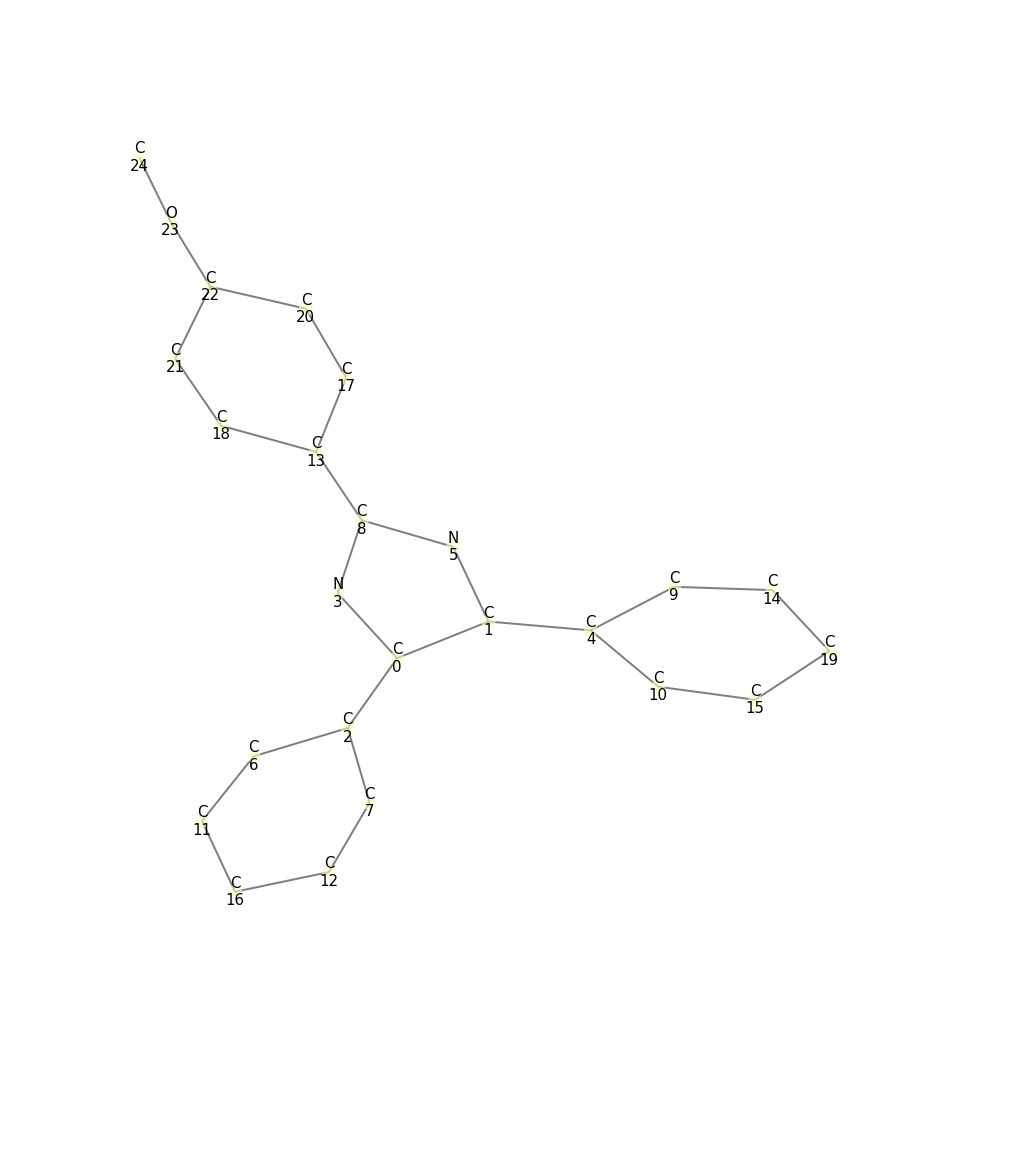

19


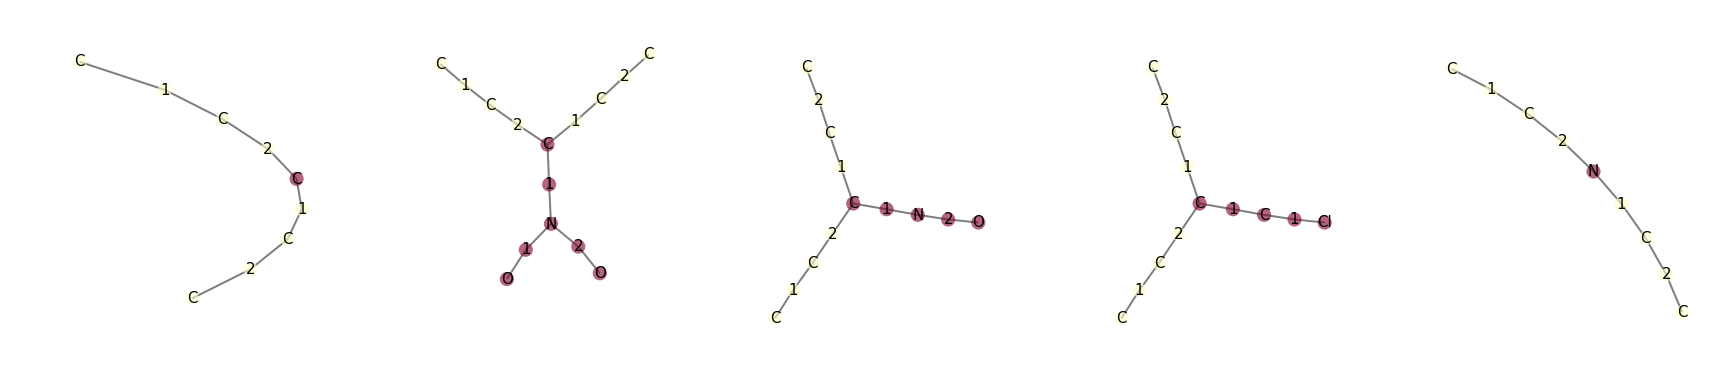

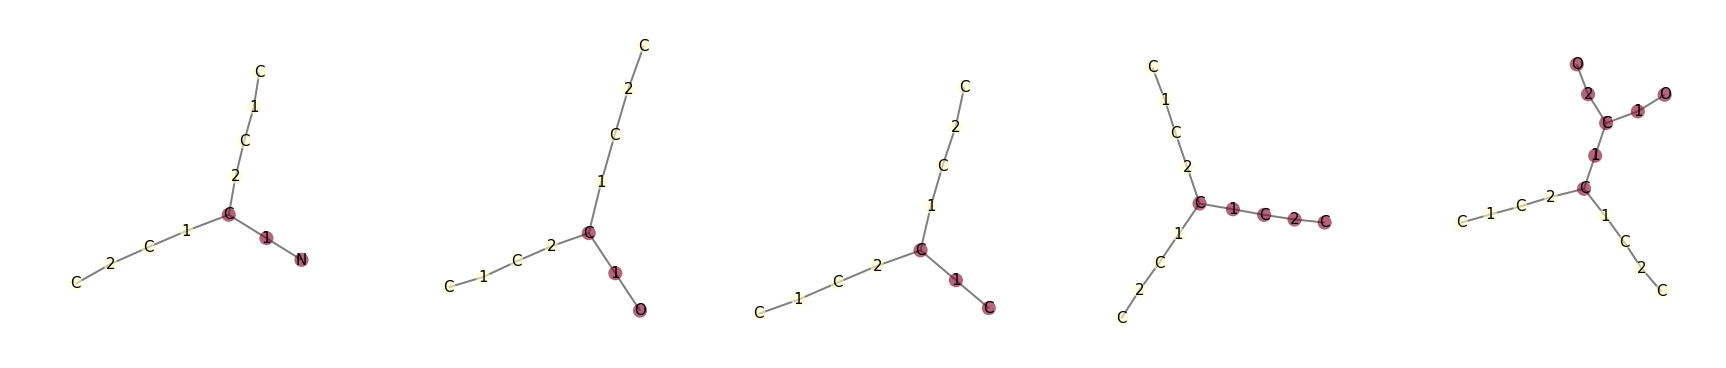

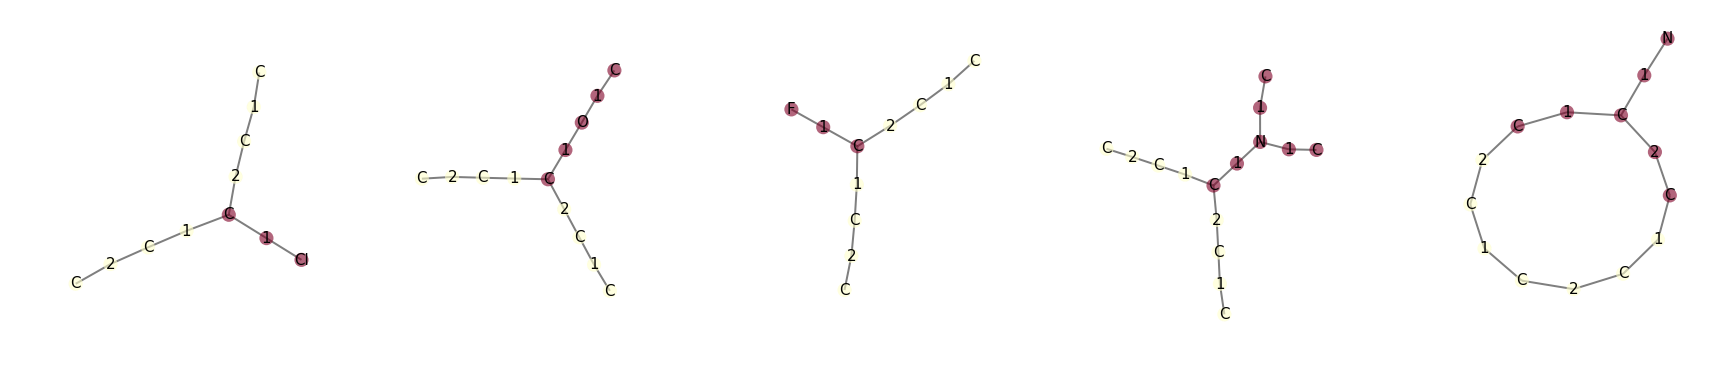

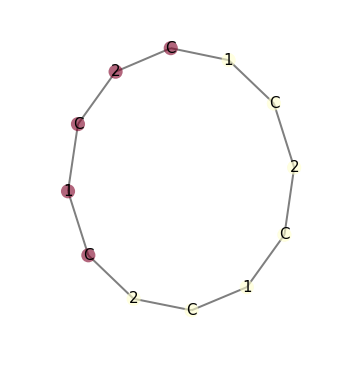

3


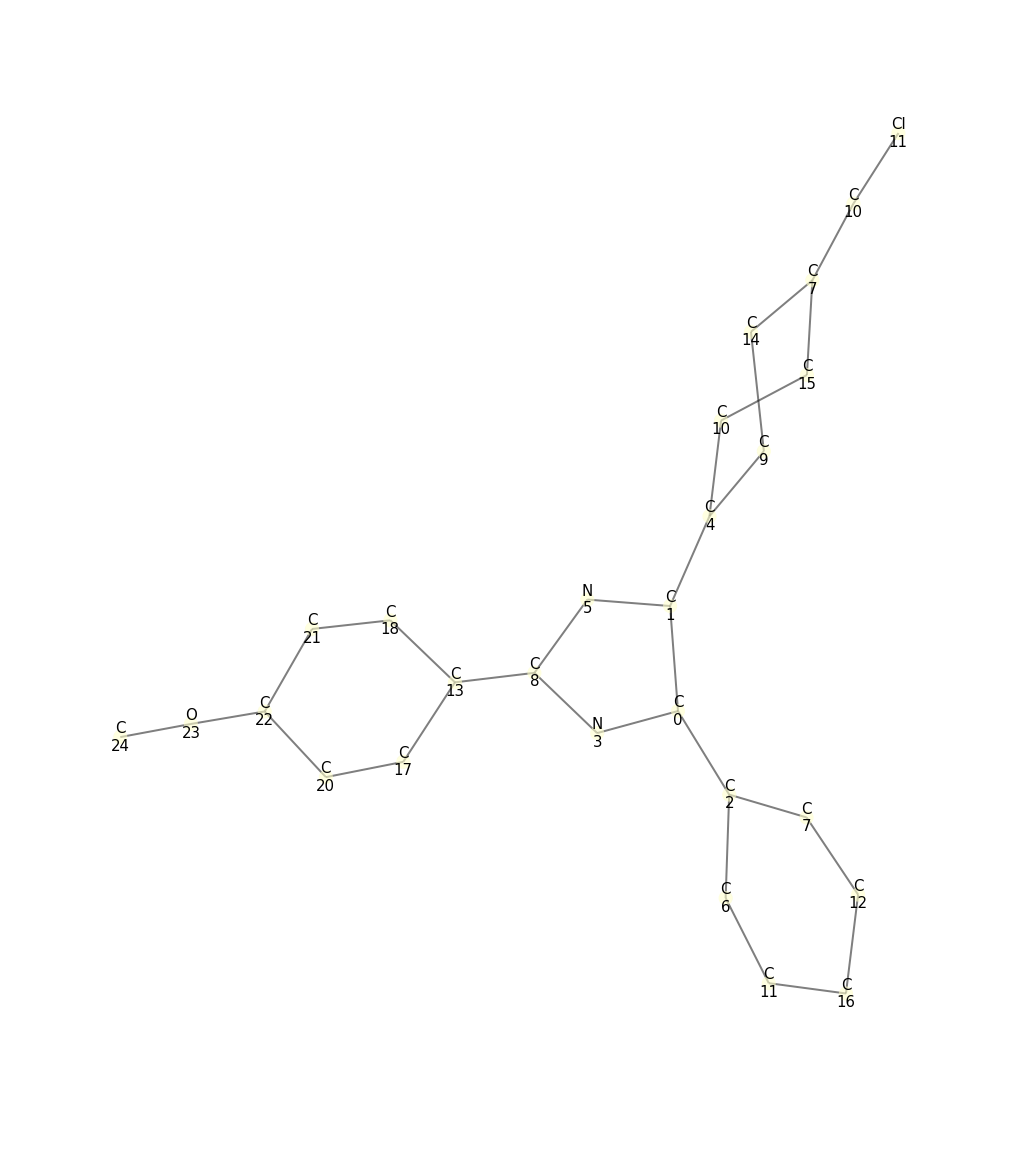

16
no replacements found,try again


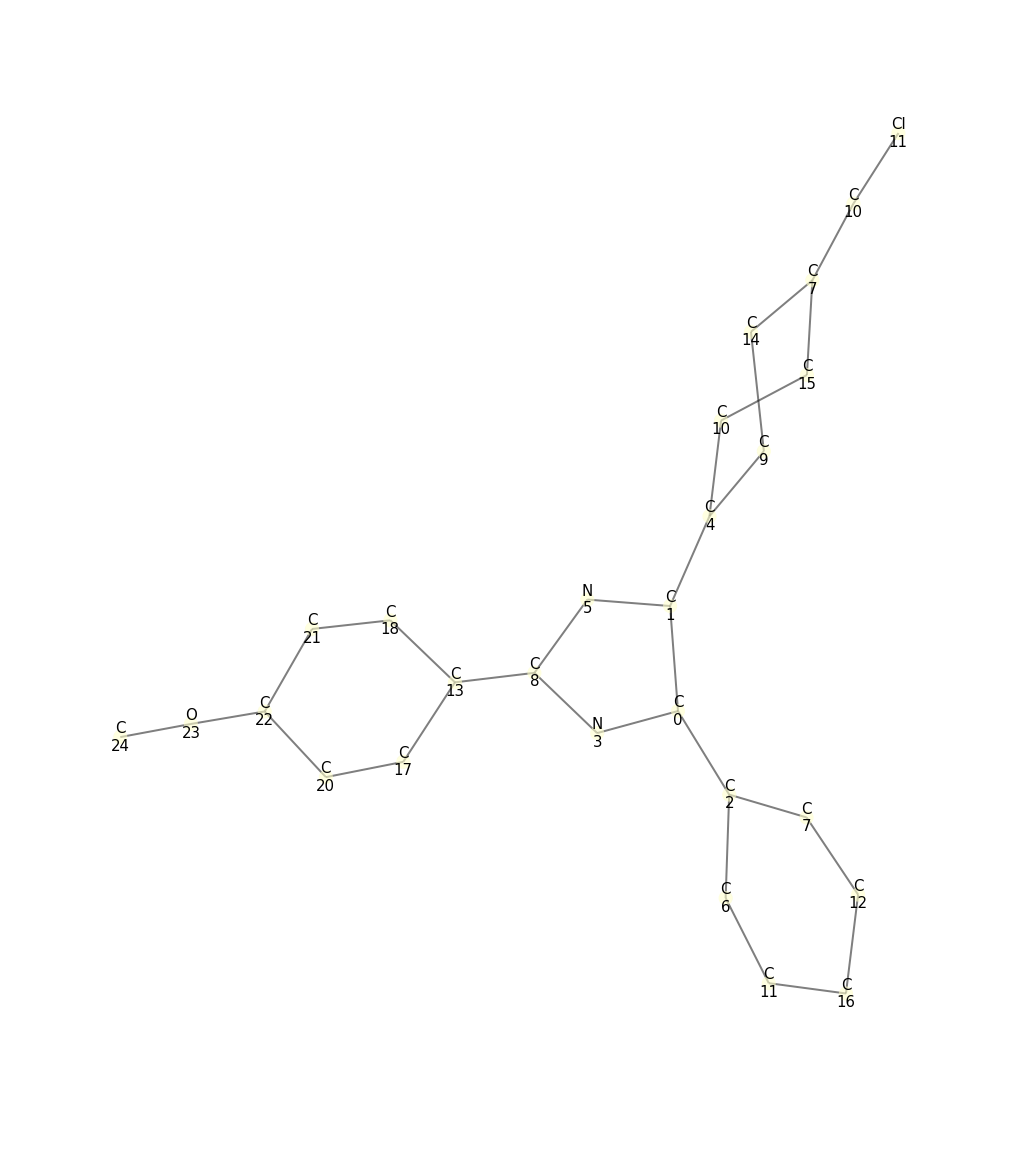

12
no replacements found,try again


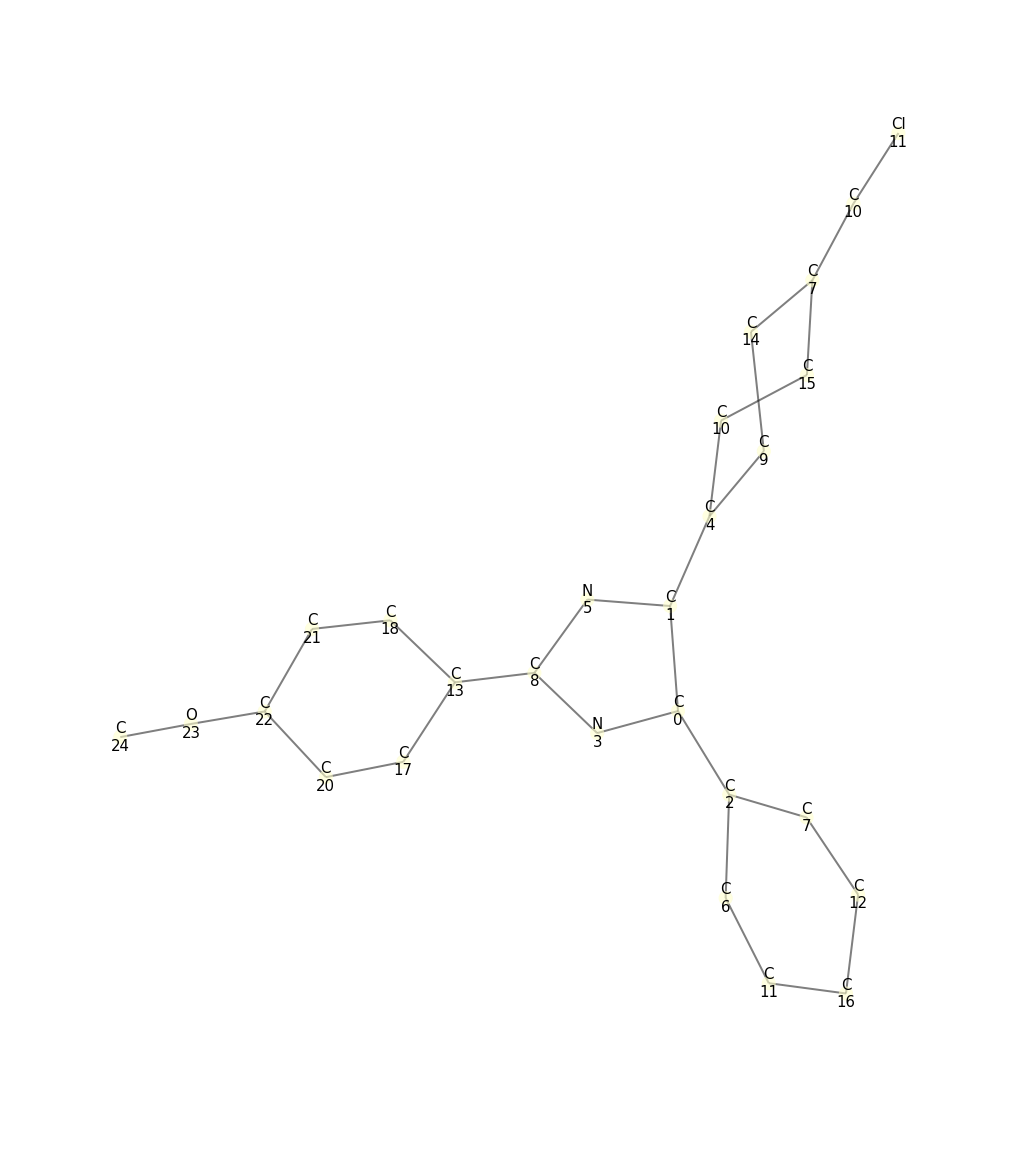

21


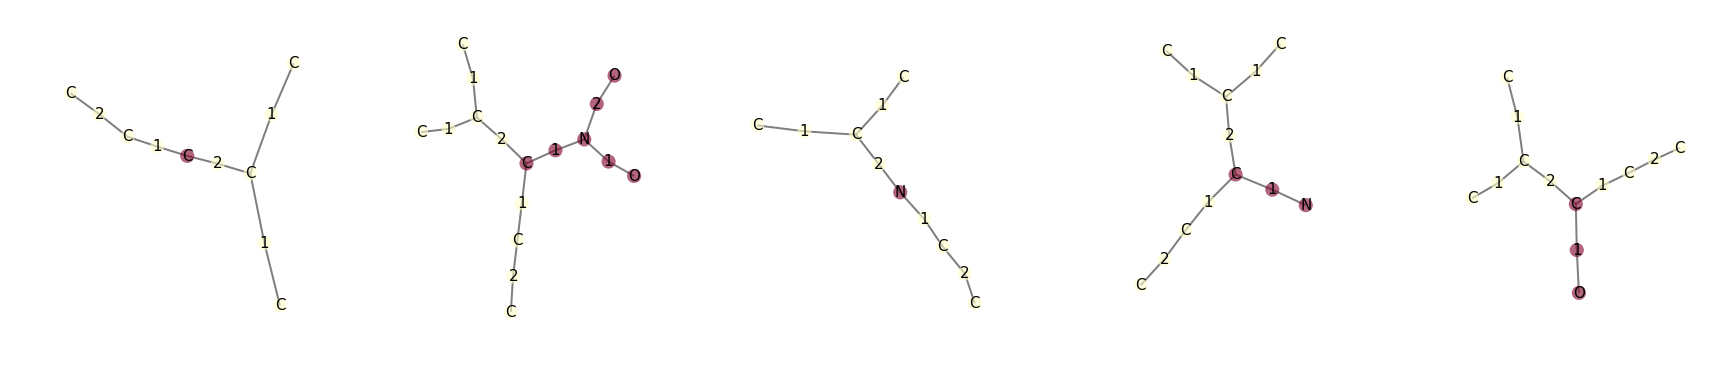

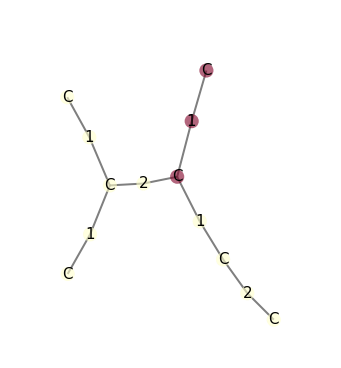

3


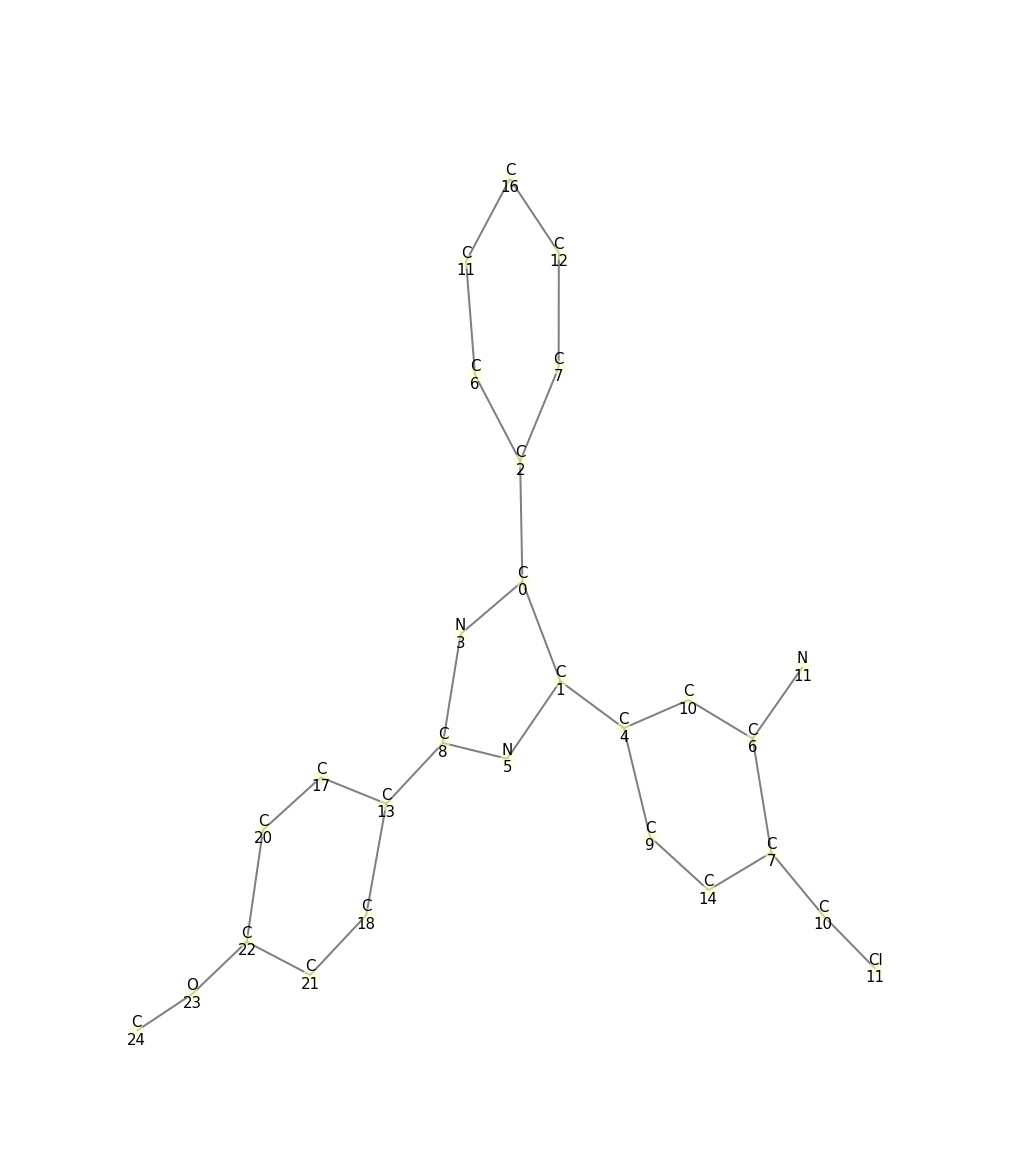

In [ ]:
'''
MAX CONTROL MODE
'''
sampler.step=3 # whatever
import networkx as nx
from graphlearn.utils import draw

d={'radius_list':sampler.radius_list,
        'thickness_list':sampler.thickness_list,
        'hash_bitmask':sampler.hash_bitmask,
        'filter':sampler.node_entity_check}


def get_new_graphs(graphwrap):
    res=[]
    graphwrap.clean()
    res= [sampler._propose(graphwrap) for i in range(8)]
    return res



def get_cips(graphman,sampler,root):
    cips = graphman.rooted_core_interface_pairs(root,**d)
    res=[]
    for cip in cips:
        if cip.interface_hash in sampler.lsgg.productions:
            new_cips=sampler.lsgg.productions[cip.interface_hash].values()
            for nc in new_cips:
                # save the original_cip_graph for replacement later
                nc.orig=cip.graph
            res+=new_cips
    return res

gr = gspan_to_eden( '../bursi.pos.gspan' )
CURRENT = sampler._sample_init(gr.next())
while True: 
    # draw graph and choose node
    draw.graphlearn(CURRENT.base_graph(),secondary_vertex_label='ID',size=20,contract=True)
    node_id=int(raw_input())
    
    # draw new cips and choose one
    cips=get_cips(CURRENT,sampler,node_id)
    if len(cips)==0:
        print 'no replacements found,try again'
        continue
    cip_graphs=[ c.graph for c in cips ]
    draw.graphlearn(cip_graphs)
    cip_id=int(raw_input())
    
    #replace and clean
    gr=CURRENT.core_substitution( cips[cip_id].orig, cip_graphs[cip_id])
    CURRENT=sampler.preprocessor.re_transform_single(gr)
    CURRENT.real_clean()
    